In [35]:
#Basic imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [93]:
# Import data
#data = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

Only for data2 processing :

In [94]:
data['Date of birth'] = pd.to_datetime(data['Date of birth'].astype(str), format='%d/%m/%Y')
data['Date of MRI scan'] = pd.to_datetime(data['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data['Age'] = (data['Date of MRI scan'] - data['Date of birth'])/ np.timedelta64(1, 'Y')

In [97]:
def clean_data(df, del_col=[], mean=[], std=[]):
    X = df.copy()
    
    # Remove useless columns
    X = X.drop(['Subject ID', 'Date of birth', 'Date of MRI scan'], axis=1)
    #X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Remove columns with only zeros
    if (len(del_col) == 0):
        del_col = (X != 0).any(axis=0)
    X = X.loc[:, del_col]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace Sex labels by values
    #X['Sex'].replace({'Male':1,'Female':2}, inplace=True)
    
    # Categorical values
    cater = X[['Gender']]
    #cater = X[['Sex']]
    
    # Numerical values
    numer = X.drop(['Gender'], axis=1)
    #numer = X.drop(['Sex'], axis=1)
    
    # Replace nan values by mean of column
    if (len(mean) == 0 or len(std) == 0):
        mean = numer.mean()
        std = numer.std()
        std = std.fillna( 1)
    numer = numer.fillna(mean)
                 
    
    #Scale each column in numer
    numer = (numer - mean)/std
    
    new_X = pd.concat([numer, cater], axis=1, join='inner')
    
    return new_X, del_col, mean, std

In [98]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(['Age'], axis=1), data['Age'], test_size=0.3, random_state=42)

In [182]:
x_train, del_col, mean_train, std_train = clean_data(data_train)
x_test, _, _, _ = clean_data(data_test, del_col, mean_train, std_train)

# Gaussian Mixture Model: 

Find the optimal number of clusters. 

In [183]:
pca = PCA(n_components=10)

pc = pca.fit_transform(x_train.drop(['Gender'], axis=1))

df_pc = pd.DataFrame(data = pc, 
                  columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

In [184]:
(pca.explained_variance_ratio_).cumsum()

array([0.6187141 , 0.70306767, 0.72998428, 0.75171291, 0.76883786,
       0.78528726, 0.79533527, 0.80482697, 0.81389934, 0.82226435])

In [185]:
# GMM CLUSTERING
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(x_train)
clusters = gmm.predict(x_train)

# Assign train samples to clusters
df_pc['GMM_Cluster'] = clusters
x_train['GMM_Cluster'] = clusters

# Assign test samples to clusters
#x_test['GMM_Cluster'] = gmm.predict(x_test.drop(['Gender'], axis=1))

In [186]:
# KMEANS CLUSTERING
kmeanModel = KMeans(n_clusters=3).fit(x_train.drop(['GMM_Cluster'], axis=1))
#kmeanModel = KMeans(n_clusters=3).fit(df_pc.drop(['GMM_Cluster'], axis=1))
df_pc['KM_Cluster'] = kmeanModel.labels_
x_train['KM_Cluster'] = kmeanModel.labels_
#x_test['KM_Cluster'] = kmeanModel.predict(x_test.drop(['Gender'], axis=1))

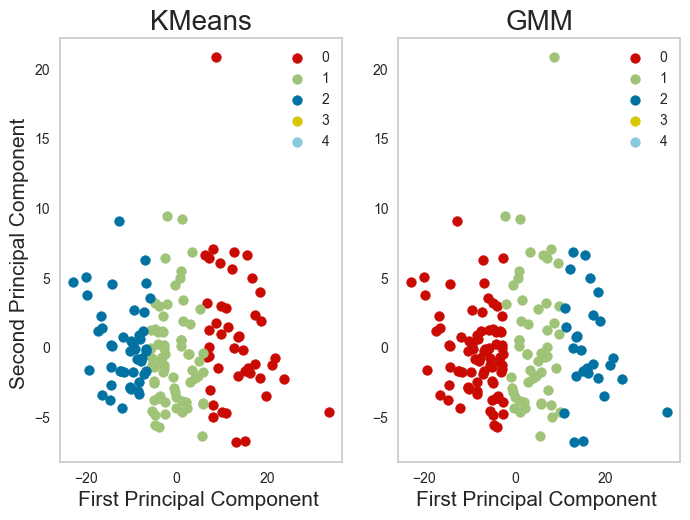

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlabel('First Principal Component ', fontsize = 15)
ax1.set_ylabel('Second Principal Component ', fontsize = 15)
ax1.set_title('KMeans', fontsize = 20)
ax2.set_xlabel('First Principal Component ', fontsize = 15)
ax2.set_title('GMM', fontsize = 20)

targets = [0, 1, 2, 3, 4]
colors = ['r', 'g', 'b', 'y', 'c']
for target, color in zip(targets, colors):
    indicesToKeep_km = df_pc['KM_Cluster'] == target
    indicesToKeep_gmm = df_pc['GMM_Cluster'] == target
    ax1.scatter(df_pc.loc[indicesToKeep_km, 'PC1'], 
               df_pc.loc[indicesToKeep_km, 'PC2'],
               c = color, 
               s = 50)
    ax2.scatter(df_pc.loc[indicesToKeep_gmm, 'PC1'], 
               df_pc.loc[indicesToKeep_gmm, 'PC2'],
               c = color, 
               s = 50)
ax1.legend(targets)
ax1.grid()
ax2.legend(targets)
ax2.grid()

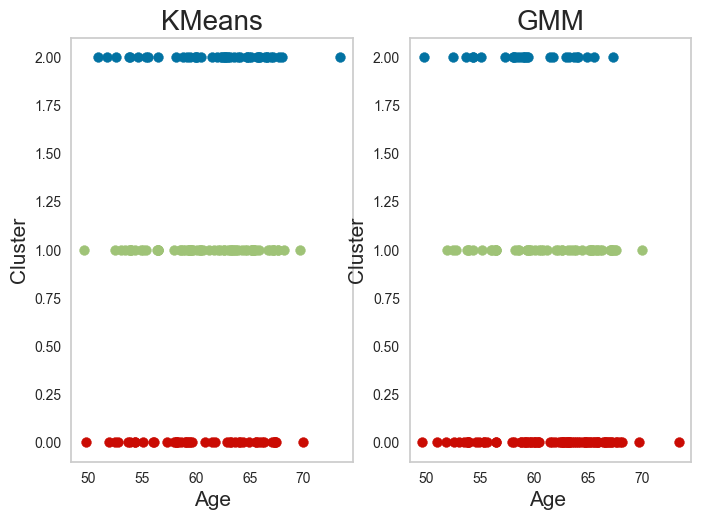

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlabel('Age', fontsize = 15)
ax1.set_ylabel('Cluster', fontsize = 15)
ax1.set_title('KMeans', fontsize = 20)
ax2.set_xlabel('Age ', fontsize = 15)
ax2.set_ylabel('Cluster', fontsize = 15)
ax2.set_title('GMM', fontsize = 20)

targets = [0, 1, 2, 3, 4]
colors = ['r', 'g', 'b', 'y', 'c']
for target, color in zip(targets, colors):
    indicesToKeep_km = x_train['KM_Cluster'] == target
    indicesToKeep_gmm = x_train['GMM_Cluster'] == target
    ax1.scatter(y_train[indicesToKeep_km],
            np.full(y_train[indicesToKeep_km].shape, target),
               c = color, 
               s = 50)
    ax2.scatter(y_train[indicesToKeep_gmm],
             np.full(y_train[indicesToKeep_gmm].shape, target),
               c = color, 
               s = 50)
ax1.grid()
ax2.grid()

In [54]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [174]:
#Compute silhouette score, which checks how much the clusters are compact and well separated.
#The closer to 1, the better.
n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(x_train) 
        labels=gmm.predict(x_train)
        sil=metrics.silhouette_score(x_train, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

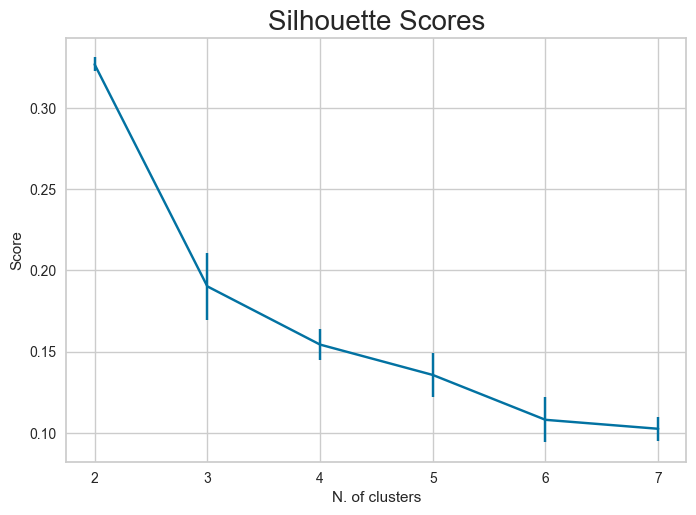

In [175]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

Number of clusters : 2

In [21]:
# Train GMM with 2 clusters
gmm = GaussianMixture(n_components=2).fit(x_train)
cluster_labels = gmm.predict(x_train)

clusters = gmm.fit(x_train)
labels = gmm.predict(x_train)

# Elastic Net Model: